In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
from scipy import stats # Import the stats module from SciPy

from models import construct_model
from datasets import SyntheticRegressionDataset, DataCorruptionConfig

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [43]:
dataset_handler = SyntheticRegressionDataset()

Generated synthetic regression dataset:
  - Samples: 100000
  - Features: 10
  - Noise std: 0.25
  - Feature range: [-4.61, 4.83]
  - Target range: [-13.69, 15.41]


In [44]:
train_loader,val_loader,test_loader =  dataset_handler.get_loaders(32, 0.6, DataCorruptionConfig())

Dataset splits:
  - Train set: 60000 samples (probabilistically corrupted)
  - Validation set: 20000 samples (clean)
  - Test set: 20000 samples (clean)


In [45]:
def corrupt_features(features, corruption_fraction):
    """
    Corrupts a batch of feature vectors by adding Gaussian noise.
    
    Args:
        features (torch.Tensor): A batch of feature vectors (B, num_features).
        corruption_fraction (float): The intensity of corruption (0.0 to 1.0).
                                   Used as noise scale relative to feature std.
    Returns:
        torch.Tensor: The batch of corrupted features.
    """
    if corruption_fraction == 0.0:
        return features
    
    # Calculate the standard deviation of features for realistic noise scaling
    feature_std = features.std()
    
    # Add noise proportional to corruption fraction and feature scale
    noise = torch.randn_like(features) * corruption_fraction * feature_std
    corrupted_features = features + noise
    
    return corrupted_features


def analyze_with_individual_corruption(data_rater, data_loader, num_batches=5, current_step=None, device='cpu'):
    """
    Analyzes the DataRater by corrupting each feature vector with a continuous random
    fraction and creating a scatter plot of scores vs. corruption.
    """
    print(f"\n--- Analyzing with Continuous Individual Corruption over {num_batches} batches --- MetaStep: {current_step}")
    data_rater.eval()  # Set the model to evaluation mode
    
    # These master lists will store the results from all batches
    all_scores = []
    all_fractions = []
    
    # Loop over the specified number of batches
    for i, (batch_features, batch_targets) in enumerate(data_loader):
        if i >= num_batches:
            break
            
        batch_features = batch_features.to(device)
        batch_size = batch_features.size(0)
        individually_corrupted_batch = torch.zeros_like(batch_features)
        fractions_for_this_batch = []
        
        # Corrupt each feature vector in the batch one by one
        for j in range(batch_size):
            # Generate a continuous random fraction between 0.0 and 1.0
            frac = np.random.uniform(0.0, 1.0)
            fractions_for_this_batch.append(frac)
            
            # Corrupt the single feature vector (note: we keep the batch dimension)
            original_features = batch_features[j:j+1]
            corrupted_features = corrupt_features(original_features, frac)
            individually_corrupted_batch[j] = corrupted_features
        
        # Get the model's scores for the entire batch of individually corrupted features
        with torch.no_grad():
            scores = data_rater(individually_corrupted_batch)
            weights = torch.softmax(scores, dim=0)
        
        # Append the results to our master lists
        all_scores.extend(weights.cpu().numpy())
        all_fractions.extend(fractions_for_this_batch)
    
    # --- Plotting and Regression Analysis ---
    plt.figure(figsize=(12, 8))
    
    # Scatter plot with continuous x-axis values
    plt.scatter(all_fractions, all_scores, alpha=0.3, label='Individual Sample Score')
    
    # Perform and plot the linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(all_fractions, all_scores)
    r_squared = r_value**2
    
    x_line = np.array([min(all_fractions), max(all_fractions)])
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line,
             color='red', linewidth=2,
             label=f'Linear Regression (R² = {r_squared:.3f})')
    
    plt.title('DataRater Score vs. Individual Feature Corruption', fontsize=16)
    plt.xlabel('Corruption Intensity (Noise Scale)')
    plt.ylabel('Raw Score (Rating)')
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.show()
    
    print(f"Regression analysis results:")
    print(f"  Slope: {slope:.4f}")
    print(f"  R²: {r_squared:.4f}")
    print(f"  P-value: {p_value:.4e}")

In [46]:
def load_data_rater_from_checkpoint(checkpoint_path, device='cpu'):
    """
    Load DataRater model using the existing construct_model function.
    """
    # Create model using the same constructor as training
    model = construct_model('RegressionDataRater')
    
    # Load the saved state dictionary
    state_dict = torch.load(checkpoint_path, map_location=device)
    
    # Load the state dict into the model
    model.load_state_dict(state_dict)
    
    # Set to evaluation mode and move to device
    model.eval()
    model = model.to(device)
    
    return model


--- Analyzing with Continuous Individual Corruption over 100 batches --- MetaStep: None


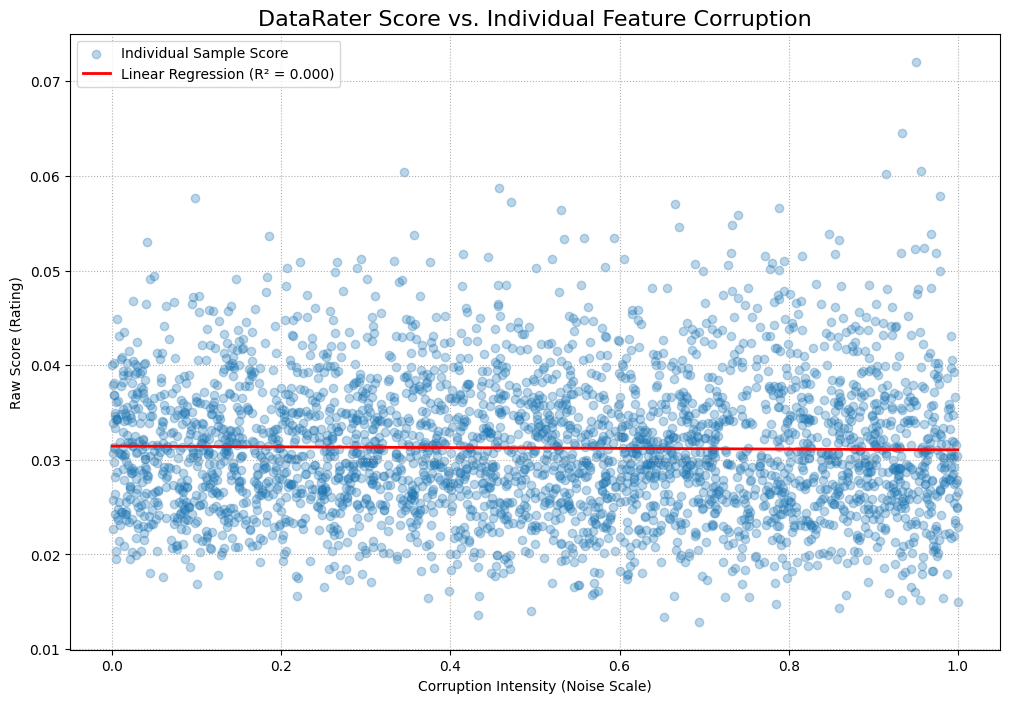

Regression analysis results:
  Slope: -0.0004
  R²: 0.0002
  P-value: 3.7299e-01


In [48]:
checkpoint_path = "experiments/synthetic1_20250914_1637_0e45578e/data_rater.pt"  # Update this path

trained_data_rater = load_data_rater_from_checkpoint(checkpoint_path, device)
analyze_with_individual_corruption(trained_data_rater, train_loader, num_batches=100)